In [1]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

import acoustotreams

k0s = 2 * np.pi * np.linspace(50000, 500000, 200) / 343
materials = [acoustotreams.AcousticMaterial(1050 + 100j, 2350 - 300j), 
             acoustotreams.AcousticMaterial(998, 1497)]
lmax = 10
radius = 0.005

spheres = [acoustotreams.AcousticTMatrix.sphere(lmax, k0, radius, materials) for k0 in k0s]
xs_sca = np.array([tm.xs_sca_avg for tm in spheres]) / (np.pi * radius ** 2)
xs_ext = np.array([tm.xs_ext_avg for tm in spheres]) / (np.pi * radius ** 2)

swb_lmax0 = acoustotreams.ScalarSphericalWaveBasis.default(1)
spheres_lmax0 = [tm[swb_lmax0] for tm in spheres]
xs_sca_lmax0 = np.array([tm.xs_sca_avg for tm in spheres_lmax0]) / (np.pi * radius ** 2)
xs_ext_lmax0 = np.array([tm.xs_ext_avg for tm in spheres_lmax0]) / (np.pi * radius ** 2)

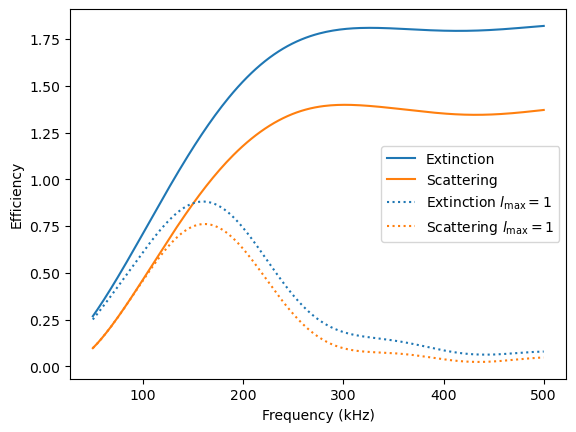

In [2]:
fig, ax = plt.subplots()
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xs_ext)
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xs_sca)
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xs_ext_lmax0, color="C0", linestyle=":")
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xs_sca_lmax0, color="C1", linestyle=":")
ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Efficiency")
ax.legend(["Extinction", "Scattering", "Extinction $l_{\\rm max}=1$", "Scattering $l_{\\rm max}=1$"])
plt.show()

In [3]:
tm = spheres[50]
inc = acoustotreams.plane_wave_scalar([0, 0, tm.k0], k0=tm.k0, material=tm.material)
sca = tm.sca(inc)

In [4]:
x = np.linspace(-0.0075, 0.0075, 101)
z = np.linspace(-0.0075, 0.0075, 101)
def compute_intensity(i, j):
    r = [x[j], 0, z[i]]
    result = 0  
    if tm.valid_points(r, [radius]): 
        result = np.abs(inc.pfield(r) + sca.pfield(r))**2  
    else:
        result = np.nan
    return i, j, result  
results = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j) for i in range(len(z)) for j in range(len(x))
)
intensity = np.zeros((len(z), len(x)))
for i, j, result in results:
    intensity[i, j] = result

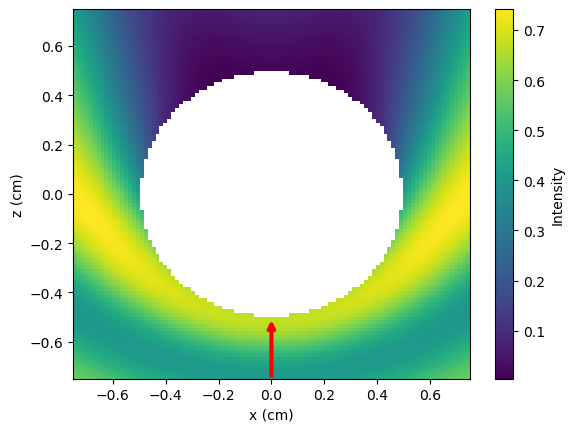

In [5]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
ax.annotate(
    "", 
    xy=(0, -0.5),
    xytext=(0, -0.75), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()

In [6]:
theta = np.linspace(0, 2 * np.pi, 301)
radpattern = np.zeros(len(theta))
def compute_radpattern(i):
    n = [np.sin(theta[i]), 0, np.cos(theta[i])]
    return 0.5 * np.real(sca.pamplitudeff(n) * np.conjugate(sca.vamplitudeff(n)[0]))
radpattern = Parallel(n_jobs=-1)(
    delayed(compute_radpattern)(i) for i in range(len(theta))
)

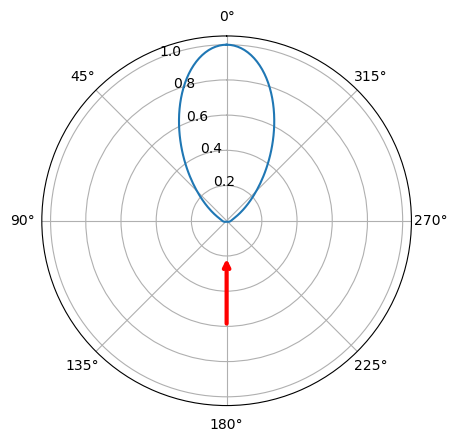

In [8]:
plt.figure()
ax = plt.subplot(111, polar=True) 
ax.plot(theta, radpattern / np.max(radpattern) )
ax.set_theta_offset(np.pi / 2)
ax.annotate(
    "", 
    xy=(np.pi, 0.2), 
    xytext=(np.pi, 0.6),
    arrowprops=dict(
        arrowstyle="->", 
        color="red", 
        lw=3
    )
)
plt.show()